# 6. Decision Trees

- Versatile models that can perform classification, regression, and multi-output tasks
- Decision trees are very easy to use and to interpret
- Decision trees require very little data preparation; they don't require feature scaling or centring
- According to Scikit-Learn it is "Possible to validate a model using statistical tests" *(how?)*
- But, they tend to overfit, particularly with a large number of features
- They are also very sensitive to small changes in the training data and are very bad for extrapolation

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# paths
ROOT_DIR = "."
IMAGES_PATH = os.path.join(ROOT_DIR, "images")

os.makedirs(
    IMAGES_PATH, exist_ok=True
)  # creates images folder, no error if it already exists


def image_path(file_name):
    return os.path.join(IMAGES_PATH, file_name)


# file names
IRIS_TREE_NAME = "iris_tree.dot"

## Training and Visualising a Decision Tree

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

# import iris sample data
iris = load_iris()

X = pd.DataFrame(data=iris["data"], columns=iris["feature_names"])
y = iris["target"]

# shuffle since data is ordered by class
X, y = shuffle(X, y)

# restrict to 2 features
X_petal = X[["petal length (cm)", "petal width (cm)"]]

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)  # max_depth determines how many branches
tree_clf.fit(X_petal, y);

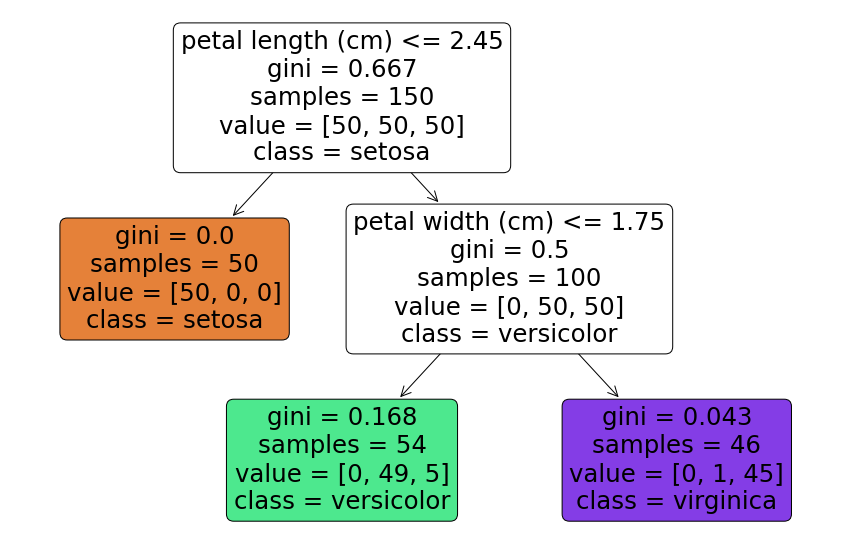

In [4]:
# visualise the tree directly
from sklearn.tree import export_graphviz, plot_tree

fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(
    tree_clf,
    feature_names=X_petal.columns,
    class_names=iris["target_names"],
    rounded=True,
    filled=True,
);

In [5]:
# or using graphviz
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    tree_clf, out_file=image_path(IRIS_TREE_NAME)
)  # saved to DOT graph description format
# graphviz.Source.from_file(image_path(IRIS_TREE_NAME))

I can't get the cell above to work - homebrew fails when trying to install graphviz

## Making Predictions

- Start at the *root node* (depth 0) and look at the first condition - go *left* if the statement is *true*
- The left child node at depth 1 is a *leaf node* - it doesn't have any child nodes and predicts class setosa
- The `samples` attribute counts how many training instances went through that node
- The `gini` attribute gives the *Gini impurity* $G$: if $p_k$ is the proportion of instances of class $k$ that go through that node then

\begin{equation}
    G = 1 - \sum_{k=1}^n p_k^2
\end{equation}

- A node is *Gini pure* ($G=0$) if all instances are of the same class
- Each node in a decision tree partitions a feature in two, so the decision boundaries are made up of vertical and horizontal lines
- Scikit-Learn uses the CART algorithm which produces only binary trees - other algorithms may have nodes with more children
- This is a 'white box' model - it is easy to understand why the model gave a particular output

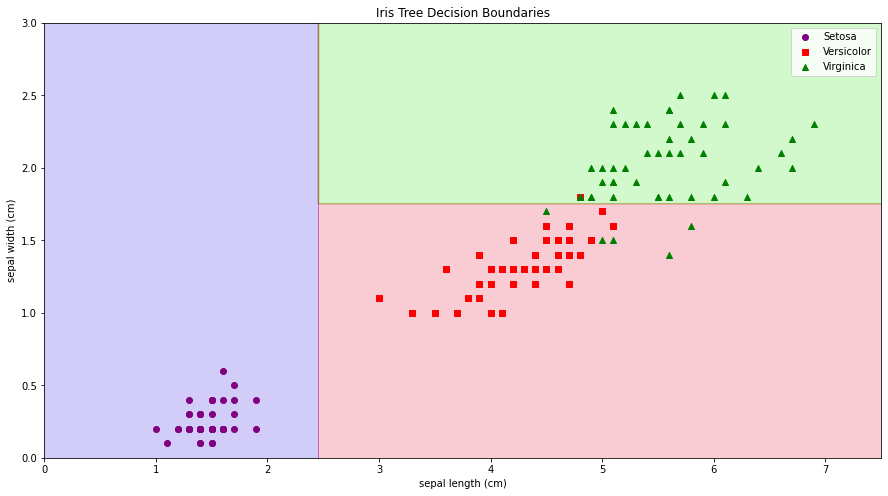

In [6]:
# decision boundaries
def plot_class_predictions(clf, xlim, ylim, ax):
    # generate values along each axis
    x0s = np.linspace(xlim[0], xlim[1], 500)
    x1s = np.linspace(ylim[0], ylim[1], 500)
    
    # all combinations of (x0, x1) for plot
    x0, x1 = np.meshgrid(x0s, x1s)

    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    
    ax.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)


def plot_data(X, y, ax):
    ax.scatter(
        X[:, 0][y == 0],
        X[:, 1][y == 0],
        marker="o",
        color="purple",
        label="Setosa"
    )
    ax.scatter(
        X[:, 0][y == 1],
        X[:, 1][y == 1],
        marker="s",
        color="red",
        label="Versicolor"
    )
    ax.scatter(
        X[:, 0][y == 2],
        X[:, 1][y == 2],
        marker="^",
        color="green",
        label="Virginica"
    )


def plot_iris_decision_boundaries(clf, ax=None, title=None):
    xlim = np.array([0, 7.5])
    ylim = np.array([0, 3])
    
    if ax == None:
        fig, ax = plt.subplots(figsize=(15, 8))

    plot_class_predictions(clf, xlim, ylim, ax)
    plot_data(X_petal.values, y, ax)

    ax.set_xlabel(X.columns[0])
    ax.set_ylabel(X.columns[1])

    ax.set_title(title)

    ax.legend()


plot_iris_decision_boundaries(tree_clf, title="Iris Tree Decision Boundaries");

## Estimating Class Probabilities

- A decision tree can estimate the probability that a given input belongs to a particular class: find the leaf node for the input and then look at what proportion of training samples at this node belong to each class
- Note that these values depend only on the leaf node for the sample (so it's quite crude)

In [7]:
# a point in the bottom right rectangle
tree_clf.predict_proba([[4, 0]])

array([[0.        , 0.90740741, 0.09259259]])

In [8]:
# ratio of classes in that rectangle
print("Setosa: {}, Versicolor: {}, Virginica {}".format(0/54, 49/54, 5/54))

Setosa: 0.0, Versicolor: 0.9074074074074074, Virginica 0.09259259259259259


In [9]:
# another point in that rectangle
tree_clf.predict_proba([[7, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

## The CART Training Algorithm

**Classification and Regression Tree (CART):** is the algorithm Scikit-Learn uses for training decision trees (there are other training algorithms)
- Repeatedly splits data at nodes into two subsets using a feature $k$ and a threshold $t_k$
- At each step it searches for the pair $(k, t_k)$ that produces the purest subsets weighted by their size by using the following cost function, where $G$ is Gini impurity and $m$ is the number of instances:

\begin{equation}
    J(k, t_k) = \frac{m_{\text{left}}}{m} G_{\text{left}} + \frac{m_{\text{right}}}{m} G_{\text{right}}
\end{equation}

- This is a *greedy* algorithm - it searches for the best improvement at each step, not necessarily the best final tree. Finding the best overall tree is *NP-Complete* (of order $O(\exp(m))$) so we settle for a 'good enough' solution
- Even with no other restrictions, this algorithm can give different outputs if run multiple times as there may be more than one split that gives the same value of $J$
- The cost function $J$ is sensitive to the sizes of different classes - if some classes dominate it is recommended to balance the dataset using weights via `class_weight`

## Computational Complexity

- Making predictions requires traversing the decision trees. Trees are approximately balanced so making predictions is $O(\log_2(m))$, independent of the number of features
- The training algorithm looks at all features on all samples at each nonde so is $O(n\times m\log_2(m))$
- Scikit-learn can speed up training for small training sets by presorting the data, but this slows down training for larger sets

## Gini Impurity or Entropy?

- We can use entropy in place of Gini impurity when training and evaluating decision trees
- The *entropy* of a discrete random variable $X$ distributed according to $p: \mathcal{X}\to [0,1]$ is

\begin{equation}
    H(X) = \mathbb{E}(-\log_2(X)) = -\sum_{x\in\mathcal{X}} p(x) \log_2p(x)
\end{equation}

- In the decision tree context this is $H = -\sum_{p_k\neq 0} p_k\log_2(p_k)$
- Entropy measures the average amount of 'information' or 'surprise' in the output of a random variable in terms of bits, e.g. if a coin that is heavily biased towards heads came up heads, this is less information than if it came up tails
- There isn't much difference using Gini impurity vs entropy - Gini impurity is slightly faster (so is a good default) and tends to isolate the most frequent class in its ow branch; entropy tends to produce slightly more balanced trees

## Regularisation Hyperparameters

- Decision trees are *nonparameteric models* - the number of parameters is not set before training and so the potential degrees of freedom are unlimited, increasig the risk of overfitting
- There are many possible regularisation parameters - increasing (resp. decreasing) `min_` (resp. `max-`) hyperparameters will increase regularisation:
    - `max_depth`: always recommended as default
    - `min_samples_split`: minimum number of samples for a node to be split
    - `min_samples_leaf`: the minimum number of samples for a leaf node
    - `min_weight_fraction_leaf`: the same but as a proportion of the total number of weighted instances
    - `max_leaf_nodes`: maximum number of leaves
    - `max_features`: maximum number of features evaluated when performing each split (chosen randomly at each split)
- You can also prune a tree after training to remove excess branches, controlled by a 'complexity' hyperparameter `ccp_alpha` (Geron says you can prune insignificant leaf nodes by applying statistical testing)

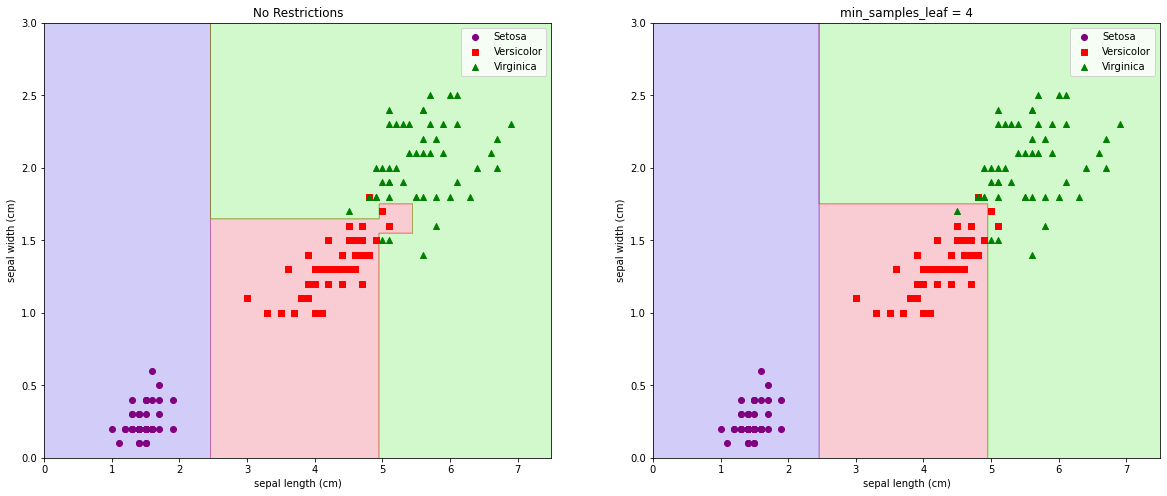

In [10]:
# effect of regularisation
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

tree_clf = DecisionTreeClassifier(random_state=42)  # no restrictions
tree_clf.fit(X_petal, y);
plot_iris_decision_boundaries(tree_clf, ax=axs[0], title="No Restrictions")

tree_clf = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)  # max_depth determines how many branches
tree_clf.fit(X_petal, y);
plot_iris_decision_boundaries(tree_clf, ax=axs[1], title="min_samples_leaf = 4")

## Regression



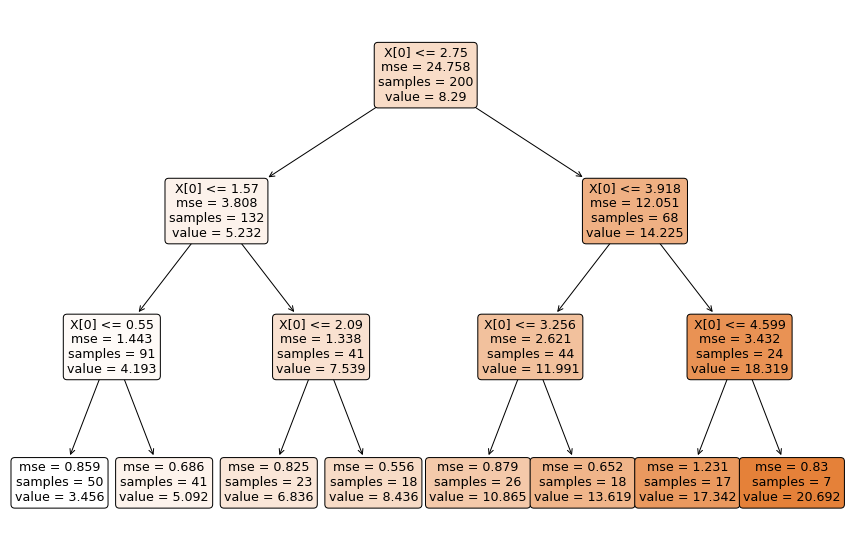

In [11]:
from sklearn.tree import DecisionTreeRegressor

# generate some sample quadratic data
n_samples = 200
X = 6 * np.random.rand(n_samples, 1) - 1
y = 0.5 * X**2 + X + 2 + 3 * np.random.rand(n_samples, 1)

# fit model
tree_reg = DecisionTreeRegressor(
    max_depth=3,
    random_state=42
)
tree_reg.fit(X, y.ravel())

fig, ax = plt.subplots(figsize=(15, 10))
plot_tree(
    tree_reg,
    rounded=True,
    filled=True,
);

- Regression works similarly to classification, except at each leaf node it predicts a value - the mean target value of the training instances at that lead
- The training algorithm using the CART algorithm which onw seeks to minimise MSE at each split:

\begin{equation}
    J(k, t_k) = \frac{m_{\text{left}}}{m} \text{MSE}_{\text{left}} + \frac{m_{\text{right}}}{m} \text{MSE}_{\text{right}}
\end{equation}

- Decision tree regressor are very prone to overfitting without regularisation

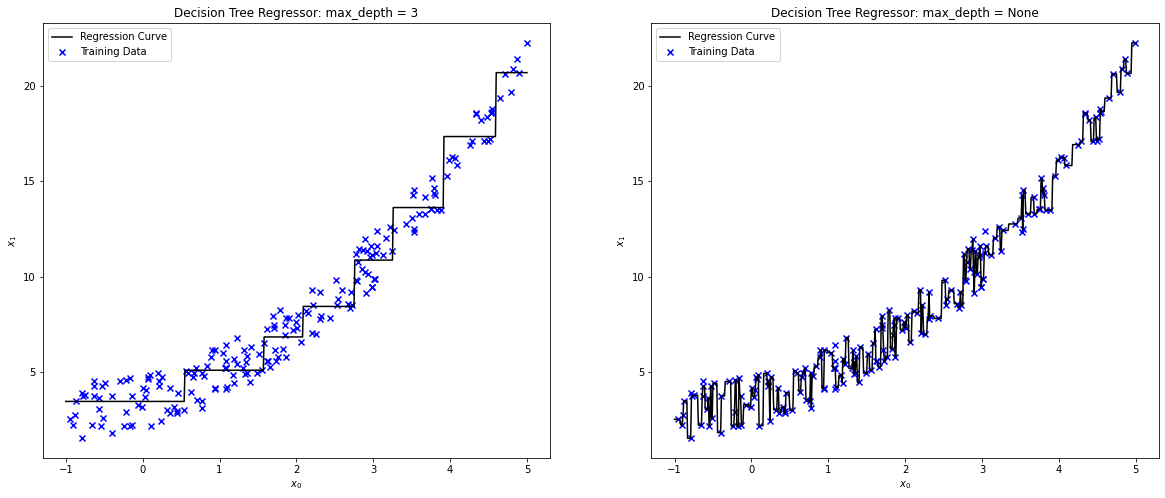

In [12]:
def plot_decision_tree_regressor(reg, ax=None):
    # generate data for plot
    x0 = np.linspace(-1, 5, 601)
    x0 = np.c_[x0]  # predict expects shape (m, 1), not (m)

    y_pred = reg.predict(x0)

    # plot curves against training data
    if not ax:
        fig, ax = plt.subplots(figsize=(15, 10))

    ax.scatter(X, y, color="blue", marker="x", label="Training Data")
    ax.plot(x0, y_pred, ls="-", color="k", label="Regression Curve")

    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")

    ax.set_title("Decision Tree Regressor: max_depth = {}".format(reg.get_params()["max_depth"]))

    ax.legend();


fig, axs = plt.subplots(1, 2, figsize=(20, 8))

plot_decision_tree_regressor(tree_reg, ax=axs[0])

tree_reg = DecisionTreeRegressor(
    random_state=42
)
tree_reg.fit(X, y.ravel())
plot_decision_tree_regressor(tree_reg, ax=axs[1])

## Instability

- Decision trees always set orthogonal decision boundaries so are sensitive to training set rotation
- You can limit this problem by applying Principal Componnent Analysis first
- Decision trees are very sensitive to small variations in the data (i.e. high variance) - they are even stochastic, giving different models on the same training data